<a href="https://colab.research.google.com/github/VirangParekh/Automated-EQ/blob/main/Speech%20Emotion%20Recognition%20new%20model/4.%20Transfer_Learning%20-%20Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install librosa

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 98% 420M/429M [00:03<00:00, 102MB/s] 
100% 429M/429M [00:03<00:00, 117MB/s]


In [ ]:
! unzip ravdess-emotional-speech-audio.zip

Archive:  ravdess-emotional-speech-audio.zip
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03-01-02-02-01.wav  
  inflating: Actor_01/03-01-03-02-01-01-01.wav  
  inflating: Actor_01/03-01-03-02-01-02-01.wav  
  inflating: Actor_01/03-01-03-02-02-01-01.wav  
  inflating: Actor_01/03

In [4]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling2D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle

In [2]:
# READ IN AUDIO FILES 
audio = "/content/drive/MyDrive/audio_speech_actors_01-24"

In [3]:
dicts={'01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}

In [4]:
path_main=audio

In [7]:
folders_main=os.listdir(path_main)
print(folders_main)

['Actor_02', 'Actor_03', 'Actor_01', 'Actor_06', 'Actor_05', 'Actor_07', 'Actor_04', 'Actor_10', 'Actor_08', 'Actor_09', 'Actor_11', 'Actor_14', 'Actor_15', 'Actor_12', 'Actor_13', 'Actor_18', 'Actor_17', 'Actor_16', 'Actor_21', 'Actor_19', 'Actor_20', 'Actor_22', 'Actor_24', 'Actor_23']


# Log-Mel Spectrogram

In [ ]:
fname = os.path.join(audio,'Actor_09/03-01-04-02-02-02-09.wav')
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

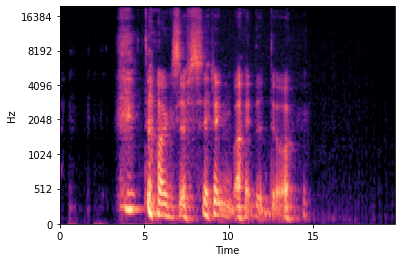

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')


09 surprised
09 neutral
09 happy
09 fearful
09 calm
09 sad
09 sad
09 angry
09 calm
09 happy
09 angry
09 calm
09 disgust
09 neutral
09 happy
09 disgust
09 disgust
09 surprised
09 fearful
09 sad
09 disgust
09 angry
09 neutral
09 angry
09 fearful
09 happy
09 calm
09 calm
09 calm
09 sad
09 fearful
09 surprised
09 sad
09 sad
09 calm
09 disgust
09 fearful
09 angry
09 angry
09 surprised
09 surprised
09 angry
09 happy
09 calm
09 disgust
09 fearful
09 disgust
09 sad
09 neutral
09 happy
09 surprised
09 surprised
09 happy
09 fearful
09 angry
09 sad
09 fearful
09 surprised
09 disgust
09 happy
04 calm
04 surprised
04 disgust
04 happy
04 disgust
04 surprised
04 fearful
04 sad
04 sad
04 sad
04 fearful
04 angry
04 happy
04 angry
04 sad
04 angry
04 disgust
04 neutral
04 calm
04 calm
04 disgust
04 disgust
04 neutral
04 disgust
04 angry
04 disgust
04 calm
04 neutral
04 surprised
04 happy
04 angry
04 angry
04 fearful
04 calm
04 happy
04 fearful
04 surprised
04 sad
04 fearful
04 surprised
04 happy
04 fearf

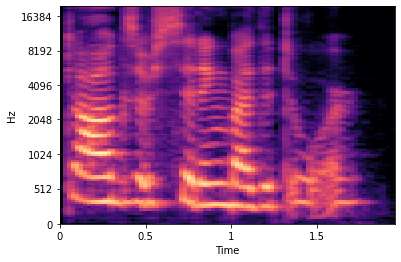

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in=r"/content/audio_speech_actors_01-24/{0}".format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        folder_create='/content/Outputs/Spectograms/{0}'.format(emotion)
        if not os.path.exists(folder_create):
          os.makedirs(folder_create)
        path_save='/content/Outputs/Spectograms/{0}/{1}.jpeg'.format(emotion,file.split(".")[0])
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Noise

In [ ]:
# FUNCTION TO ADD WHITE NOISE
def noise(y):
    noise_amp = 0.05*np.random.uniform()*np.amax(y)   
    y = y.astype('float64') + noise_amp * np.random.normal(size=y.shape[0])
    return y

In [ ]:
fname = os.path.join(audio,'Actor_09/03-01-04-02-02-02-09.wav')
# fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

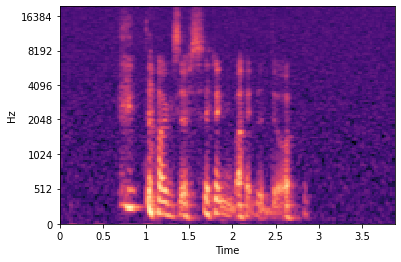

In [ ]:
y = noise(y)
y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
db_spec = librosa.power_to_db(y)
librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time')

02 angry
02 sad
02 happy
02 angry
02 angry
02 angry
02 sad
02 happy
02 calm
02 neutral
02 calm
02 happy
02 calm
02 sad
02 happy
02 calm
02 neutral
02 sad
02 neutral
02 calm
02 calm
02 sad
02 happy
02 angry
02 calm
02 sad
02 happy
02 calm
02 sad
02 neutral
02 sad
02 angry
02 happy
02 happy
02 disgust
02 surprised
02 disgust
02 fearful
02 disgust
02 surprised
02 surprised
02 fearful
02 disgust
02 surprised
02 fearful
02 disgust
02 surprised
02 fearful
02 angry
02 fearful
02 surprised
02 fearful
02 disgust
02 disgust
02 disgust
02 surprised
02 fearful
02 angry
02 fearful
02 surprised
03 sad
03 sad
03 happy
03 sad
03 happy
03 happy
03 neutral
03 happy
03 neutral
03 happy
03 happy
03 happy
03 sad
03 neutral
03 neutral
03 calm
03 calm
03 calm
03 calm
03 calm
03 sad
03 sad
03 happy
03 calm
03 calm
03 sad
03 calm
03 fearful
03 surprised
03 angry
03 angry
03 angry
03 surprised
03 disgust
03 surprised
03 angry
03 disgust
03 disgust
03 angry
03 disgust
03 surprised
03 surprised
03 fearful
03 fear

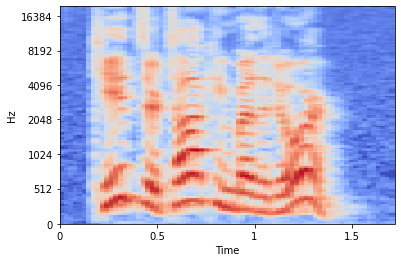

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in=r"/content/drive/MyDrive/audio_speech_actors_01-24/{0}".format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        folder_create='/content/drive/MyDrive/Outputs/Noise/{0}'.format(emotion)
        if not os.path.exists(folder_create):
          os.makedirs(folder_create)
        path_save='/content/drive/MyDrive/Outputs/Noise/{0}/{1}.jpeg'.format(emotion,file.split(".")[0])
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y = noise(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Stretch

In [ ]:
# FUNCTION TO STRETCH THE SOUND
def stretch(y, rate=0.8):
    data = librosa.effects.time_stretch(y, rate)
    return data

In [ ]:
fname = os.path.join(audio,'Actor_09/03-01-04-02-02-02-09.wav')
# fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

In [ ]:
y=yt

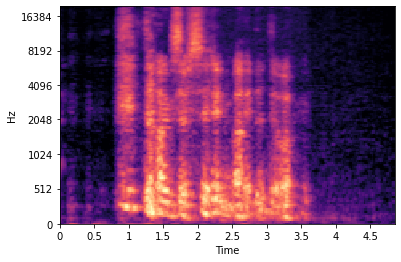

In [ ]:
y= stretch(y)
y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
db_spec = librosa.power_to_db(y)
librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');

16 angry
16 fearful
16 fearful
16 angry
16 disgust
16 sad
16 sad
16 disgust
16 surprised
16 surprised
16 happy
16 happy
16 calm
16 neutral
16 calm
16 happy
16 happy
16 calm
16 calm
16 neutral
16 fearful
16 angry
16 angry
16 fearful
16 sad
16 disgust
16 disgust
16 sad
16 surprised
16 surprised
16 calm
16 neutral
16 calm
16 happy
16 happy
16 disgust
16 sad
16 sad
16 disgust
16 angry
16 fearful
16 fearful
16 angry
16 surprised
16 surprised
16 sad
16 disgust
16 disgust
16 sad
16 fearful
16 angry
16 angry
16 fearful
16 surprised
16 surprised
16 neutral
16 calm
16 calm
16 happy
16 happy
11 neutral
11 calm
11 calm
11 happy
11 happy
11 sad
11 disgust
11 disgust
11 sad
11 fearful
11 angry
11 angry
11 fearful
11 surprised
11 surprised
11 disgust
11 sad
11 sad
11 disgust
11 angry
11 fearful
11 fearful
11 angry
11 surprised
11 surprised
11 calm
11 neutral
11 calm
11 happy
11 happy
11 fearful
11 angry
11 angry
11 fearful
11 sad
11 disgust
11 disgust
11 sad
11 surprised
11 surprised
11 happy
11 happ

15 neutral
15 calm
15 happy
15 happy
23 disgust
23 sad
23 sad
23 disgust
23 angry
23 fearful
23 fearful
23 angry
23 surprised
23 surprised
23 calm
23 neutral
23 calm
23 happy
23 happy
23 neutral
23 calm
23 calm
23 happy
23 happy
23 sad
23 disgust
23 disgust
23 sad
23 fearful
23 angry
23 angry
23 fearful
23 surprised
23 surprised
23 happy
23 happy
23 calm
23 neutral
23 calm
23 angry
23 fearful
23 fearful
23 angry
23 disgust
23 sad
23 sad
23 disgust
23 surprised
23 surprised
23 fearful
23 angry
23 angry
23 fearful
23 sad
23 disgust
23 disgust
23 sad
23 surprised
23 surprised
23 happy
23 happy
23 calm
23 calm
23 neutral
24 happy
24 happy
24 calm
24 calm
24 neutral
24 fearful
24 angry
24 angry
24 fearful
24 sad
24 disgust
24 disgust
24 sad
24 surprised
24 surprised
24 angry
24 fearful
24 fearful
24 angry
24 disgust
24 sad
24 sad
24 disgust
24 surprised
24 surprised
24 happy
24 happy
24 calm
24 neutral
24 calm
24 sad
24 disgust
24 disgust
24 sad
24 fearful
24 angry
24 angry
24 fearful
24 su

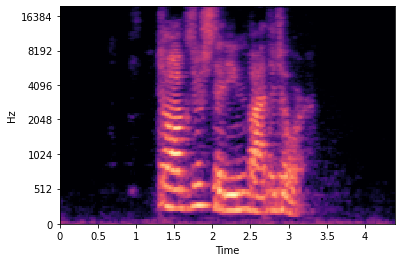

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in=r"/content/drive/MyDrive/audio_speech_actors_01-24/{0}".format(folders)
    # path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        folder_create='/content/drive/MyDrive/Outputs/Stretch/{0}'.format(emotion)
        if not os.path.exists(folder_create):
          os.makedirs(folder_create)
        path_save='/content/drive/MyDrive/Outputs/Stretch/{0}/{1}.jpeg'.format(emotion,file.split(".")[0])
        # path_save='/Users/murielkosaka/Desktop/capstone_project/audio/stretch/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y= stretch(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Speed N Pitch

In [8]:
fname = os.path.join(audio,'Actor_09/03-01-04-02-02-02-09.wav')
# fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

In [9]:
y=yt

In [10]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(y):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(y),speed_fac),np.arange(0,len(y)),y)
    minlen = min(y.shape[0], tmp.shape[0])
    y *= 0
    y[0:minlen] = tmp[0:minlen]
    return y

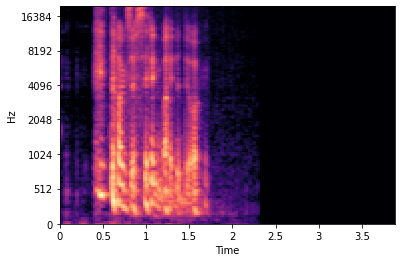

In [11]:
y= speedNpitch(y)
y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
db_spec = librosa.power_to_db(y)
librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');

02 angry
02 sad
02 happy
02 angry
02 angry
02 angry
02 sad
02 happy
02 calm
02 neutral
02 calm
02 happy
02 calm
02 sad
02 happy
02 calm
02 neutral
02 sad
02 neutral
02 calm
02 calm
02 sad
02 happy
02 angry
02 calm
02 sad
02 happy
02 calm
02 sad
02 neutral
02 sad
02 angry
02 happy
02 happy
02 disgust
02 surprised
02 disgust
02 fearful
02 disgust
02 surprised
02 surprised
02 fearful
02 disgust
02 surprised
02 fearful
02 disgust
02 surprised
02 fearful
02 angry
02 fearful
02 surprised
02 fearful
02 disgust
02 disgust
02 disgust
02 surprised
02 fearful
02 angry
02 fearful
02 surprised
03 sad
03 sad
03 happy
03 sad
03 happy
03 happy
03 neutral
03 happy
03 neutral
03 happy
03 happy
03 happy
03 sad
03 neutral
03 neutral
03 calm
03 calm
03 calm
03 calm
03 calm
03 sad
03 sad
03 happy
03 calm
03 calm
03 sad
03 calm
03 fearful
03 surprised
03 angry
03 angry
03 angry
03 surprised
03 disgust
03 surprised
03 angry
03 disgust
03 disgust
03 angry
03 disgust
03 surprised
03 surprised
03 fearful
03 fear

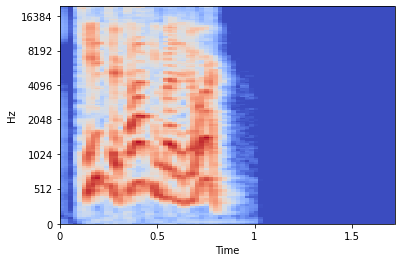

In [12]:
import re
counter=0
for folders in folders_main :
    path_in=r"/content/drive/MyDrive/audio_speech_actors_01-24/{0}".format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        folder_create='/content/drive/MyDrive/Outputs/SpeedNPitch/{0}'.format(emotion)
        if not os.path.exists(folder_create):
          os.makedirs(folder_create)
        path_save='/content/drive/MyDrive/Outputs/SpeedNPitch/{0}/{1}.jpeg'.format(emotion,file.split(".")[0])
        # path_save='/Users/murielkosaka/Desktop/capstone_project/audio/stretch/{0}/{1}.jpeg'.format(emotion,file)
        # path_save='/Users/murielkosaka/Desktop/capstone_project/audio/speednpitch/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y= speedNpitch(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/Users/murielkosaka/Desktop/capstone_project/audio/speednpitch/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y= speedNpitch(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Transfer Learning

## Attach labels to Stretch

In [2]:
import glob
angry = glob.glob('/content/drive/MyDrive/Outputs/Stretch/angry/*.*')
calm = glob.glob('/content/drive/MyDrive/Outputs/Stretch/calm/*.*')
disgust = glob.glob('/content/drive/MyDrive/Outputs/Stretch/disgust/*.*')
fearful = glob.glob('/content/drive/MyDrive/Outputs/Stretch/fearful/*.*')
happy = glob.glob('/content/drive/MyDrive/Outputs/Stretch/happy/*.*')
neutral = glob.glob('/content/drive/MyDrive/Outputs/Stretch/neutral/*.*')
sad = glob.glob('/content/drive/MyDrive/Outputs/Stretch/sad/*.*')
surprised = glob.glob('/content/drive/MyDrive/Outputs/Stretch/surprised/*.*')

In [5]:
data = []
labels = []

for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Sad')
for i in surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Surprised')

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,random_state=22, stratify=labels)

# X_model, X_test, y_model, y_test = train_test_split(data, labels, test_size=0.3,random_state=22, stratify=labels)
# X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.3,random_state=22,stratify=y_model)

In [6]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for labels in os.listdir(directory): 
        if labels == 'angry': 
            label = 'angry'
        elif labels == 'calm':
            label = 'calm'
        elif labels == 'disgust':
            label = 'disgust'
        elif labels == 'fearful':
            label = 'fearful'
        elif labels == 'happy':
            label = 'happy'
        elif labels == 'neutral':
            label = 'neutral'
        elif labels == 'sad':
            label = 'sad'
        elif labels == 'surprised':
            label = 'surprised'
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(75,75)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            # image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {'angry':'angry', 'calm':'calm', 'disgust':'disgust', 'fearful':'fearful', 'happy':'happy', 'neutral':'neutral','sad':'sad','surprised':'surprised'}
    
    return labels[class_code]

In [7]:
Images, Labels = get_images('/content/drive/MyDrive/Outputs/Stretch/') #Extract the training images from the folders.


# Process Images for Transfer Learning

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.3,random_state=22, stratify=Labels)

# X_model, X_test, y_model, y_test = train_test_split(Images, Labels, test_size=0.3,random_state=22, stratify=Labels)
# X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.3,random_state=22,stratify=y_model)


In [22]:
!pip install np_utils

     |████████████████████████████████| 61 kB 461 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=b675f5a7510168d06f737903e2068b818a14c66b1af03855bbf124928d931afd
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [9]:
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

lb = LabelEncoder()

X_train=np.array(X_train)
X_test=np.array(X_test)/255
# # X_val=np.array(X_val)/255

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# y_val=np_utils.to_categorical(lb.fit_transform(y_val))
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [10]:
X_test.shape

(378, 75, 75, 3)

In [11]:
X_train.shape

(879, 75, 75, 3)

In [12]:
print(y_test)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [13]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


# VGG16

In [15]:
from keras import applications

model = applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (75, 75, 3),pooling='avg')

58900480/58889256 [==============================] - 1s 0us/step


In [16]:
# freezing the layers 
for layer in model.layers[:17]:
    layer.trainable = False


#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

In [17]:
predictions = Dense(8, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [18]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [19]:
history = model_final.fit(X_train,y_train, batch_size=32,epochs= 10, validation_data= (X_test,y_test))


Epoch 1/10
28/28 [==============================] - 16s 139ms/step - loss: 2.0273 - accuracy: 0.2173 - val_loss: 2.3915 - val_accuracy: 0.1323
Epoch 2/10
28/28 [==============================] - 2s 83ms/step - loss: 1.7928 - accuracy: 0.3197 - val_loss: 2.6846 - val_accuracy: 0.1323
Epoch 3/10
28/28 [==============================] - 2s 84ms/step - loss: 1.6899 - accuracy: 0.3595 - val_loss: 2.8547 - val_accuracy: 0.1323
Epoch 4/10
28/28 [==============================] - 2s 84ms/step - loss: 1.5483 - accuracy: 0.4243 - val_loss: 2.9714 - val_accuracy: 0.1323
Epoch 5/10
28/28 [==============================] - 2s 83ms/step - loss: 1.4311 - accuracy: 0.4664 - val_loss: 2.9601 - val_accuracy: 0.1323
Epoch 6/10
28/28 [==============================] - 2s 85ms/step - loss: 1.3274 - accuracy: 0.5142 - val_loss: 3.6743 - val_accuracy: 0.1323
Epoch 7/10
28/28 [==============================] - 2s 84ms/step - loss: 1.3330 - accuracy: 0.4937 - val_loss: 3.6763 - val_accuracy: 0.1323
Epoch 8/10


In [ ]:
60,55

In [20]:
!pip install split-folders

In [21]:
import splitfolders
output = '/content/drive/MyDrive/SplitDS'
splitfolders.ratio('/content/drive/MyDrive/Outputs/Spectograms', output=output, seed=1337, ratio=(0.7,0.3)) 

Copying files: 1440 files [01:38, 14.55 files/s]


Text(0.5, 1.0, 'Number of training images per category:')

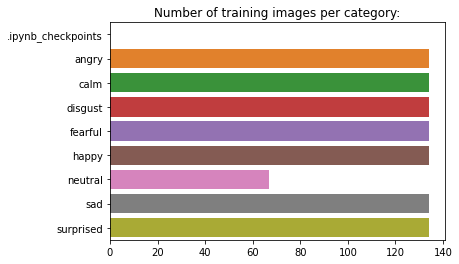

In [22]:
train_data_dir = "/content/drive/MyDrive/SplitDS/train"
val_data_dir = "/content/drive/MyDrive/SplitDS/val"
# test_data_dir = "audio/data/test"
category_names = sorted(os.listdir('/content/drive/MyDrive/SplitDS/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = '/content/drive/MyDrive/SplitDS/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")


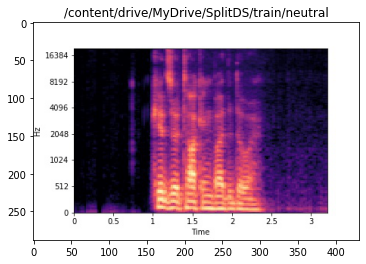

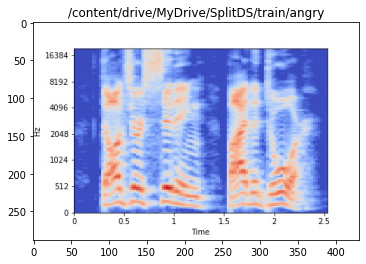

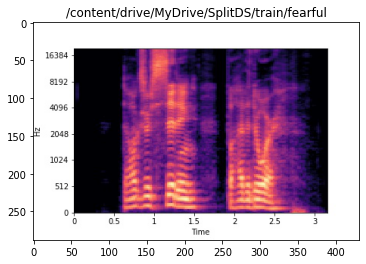

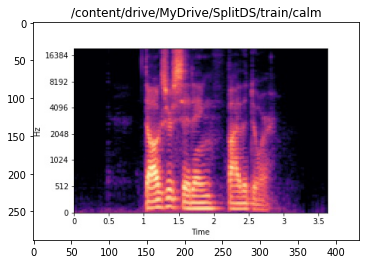

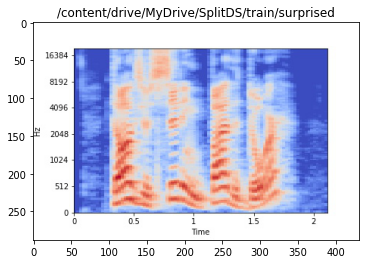

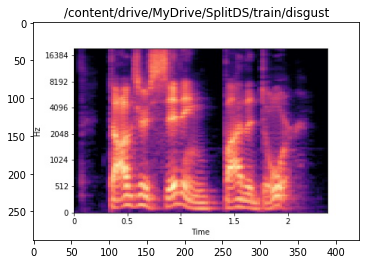

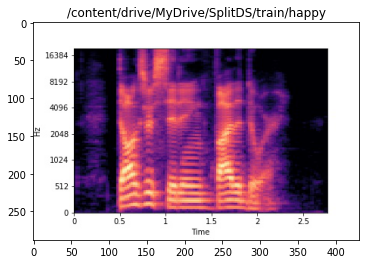

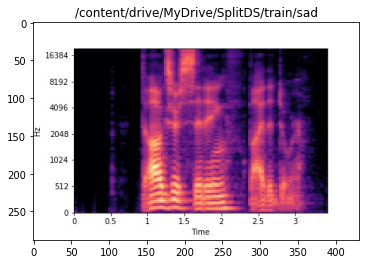

In [25]:
# example of converting an image with the Keras API
from keras.preprocessing.image import load_img

for subdir, dirs, files in os.walk('/content/drive/MyDrive/SplitDS/train'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break


In [26]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
img_height, img_width = 224,224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))


In [27]:
for layer in conv_base.layers[:-13]:
    layer.trainable = False


In [28]:
from tensorflow.python.keras import layers, models, Model, optimizers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()


ValueError: ignored

In [ ]:
#Number of images to load at each iteration
batch_size = 32
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")
print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)
print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)


In [ ]:
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

learning_rate = 5e-5
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])


In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=val_generator,
                              )

# New VGG16

Text(0.5, 1.0, 'Number of training images per category:')

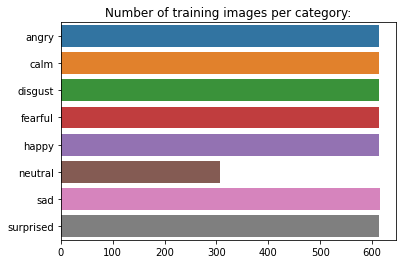

In [ ]:
train_data_dir = "/content/drive/My Drive/data/train"
val_data_dir = "/content/drive/My Drive/data/validation"
test_data_dir = "/content/drive/My Drive/data/test"
category_names = sorted(os.listdir('/content/drive/My Drive/data/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = '/content/drive/My Drive/data/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [ ]:
for subdir, dirs, files in os.walk('data/train'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
img_height, img_width = 224,224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape = (img_width, img_height, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4ec451e940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f146b34e0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f156fe6d8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4ec4058128> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4ec0417630> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4ec04204a8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4ec04208d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4ec042a0f0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4ec042af28> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4ec04333c8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4ec0433c18> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4ec043c

In [ ]:
for layer in conv_base.layers[:-13]:
    layer.trainable = False

In [ ]:
from tensorflow.python.keras import layers, models, Model, optimizers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.25))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img

#Number of images to load at each iteration
batch_size = 32
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)
val_datagen =  ImageDataGenerator(
    rescale=1./255
)
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")
print('Total number of images for "validation":')
val_generator = val_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)
print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 4605 images belonging to 8 classes.
Total number of images for "validation":
Found 585 images belonging to 8 classes.
Total number of images for "testing":
Found 570 images belonging to 8 classes.


In [ ]:
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

learning_rate = 5e-5
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=False, 
                              validation_data=val_generator,
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
288/288 [==============================] - 2254s 8s/step - loss: 2.0790 - acc: 0.1338 - val_loss: 2.0624 - val_acc: 0.1333
Epoch 2/10
288/288 [==============================] - 80s 277ms/step - loss: 2.0650 - acc: 0.1299 - val_loss: 2.0695 - val_acc: 0.1470
Epoch 3/10
288/288 [==============================] - 80s 277ms/step - loss: 2.0361 - acc: 0.1613 - val_loss: 1.9316 - val_acc: 0.1709
Epoch 4/10
288/288 [==============================] - 80s 278ms/step - loss: 1.9310 - acc: 0.2450 - val_loss: 1.6827 - val_acc: 0.3470
Epoch 5/10
288/288 [==============================] - 80s 278ms/step - loss: 1.6828 - acc: 0.3516 - val_loss: 1.4740 - val_acc: 0.4034
Epoch 6/10
288/288 [==============================] - 80s 278ms/step - loss: 1.5178 - acc: 0.4063 - val_loss: 1.3480 - val_acc: 0.4855
Epoch 7/10
288/288 [==============================] - 80s 278ms/step - loss: 1.3461 - acc: 0.4814 - val_loss: 1.242

In [ ]:
79

79

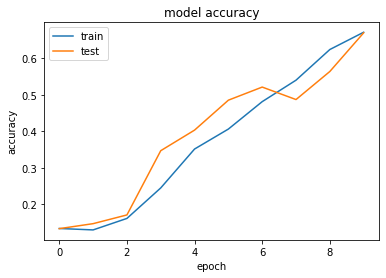

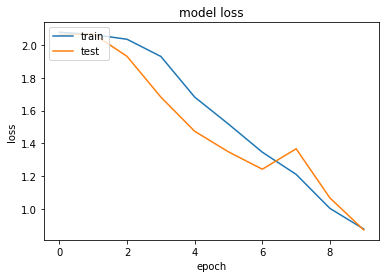

In [ ]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')


Instructions for updating:
Please use Model.predict, which supports generators.
Confusion matrix, without normalization


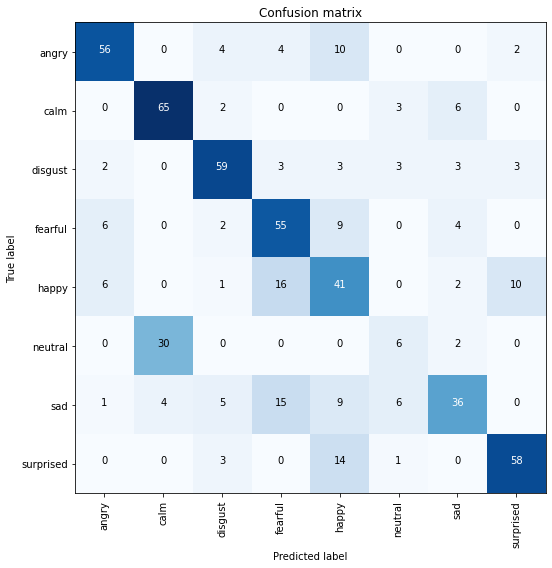

In [ ]:
 import numpy as np
 import matplotlib.pyplot as plt
 import itertools
cmap=plt.cm.Blues
title='Confusion matrix'
classes = category_names
normalize=False
figname = 'Confusion_matrix_concrete.jpg'

def plot_confusion_matrix(cm, classes, figname, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print("Confusion matrix, without normalization")
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest", cmap=cmap)
plt.title(title)
 #plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
fmt = ".2f" if normalize else "d"
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.tight_layout()
  plt.savefig(figname)

In [ ]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 66.0% 


# Inception

In [ ]:
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

img_height, img_width = 224,224

imagenet=inception_v3.InceptionV3(weights='imagenet',pooling='avg',include_top=False, input_shape=(img_height, img_width,3))

In [ ]:
for layer in imagenet.layers[:1]:
    layer.trainable=False

In [ ]:
from tensorflow.python.keras import layers, models, Model, optimizers
model = models.Sequential()
model.add(imagenet)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_76 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_79 (Dense)             (None, 128)             

In [ ]:
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

learning_rate = 5e-5
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=val_generator,
                              )

Epoch 1/10
288/288 [==============================] - 44s 154ms/step - loss: 0.6193 - acc: 0.8421 - val_loss: 1.0160 - val_acc: 0.7248
Epoch 2/10
288/288 [==============================] - 42s 146ms/step - loss: 0.1818 - acc: 0.9472 - val_loss: 1.3900 - val_acc: 0.7094
Epoch 3/10
288/288 [==============================] - 43s 148ms/step - loss: 0.1824 - acc: 0.9494 - val_loss: 1.2624 - val_acc: 0.7248
Epoch 4/10
288/288 [==============================] - 42s 147ms/step - loss: 0.1187 - acc: 0.9672 - val_loss: 1.2081 - val_acc: 0.7316
Epoch 5/10
288/288 [==============================] - 42s 147ms/step - loss: 0.1055 - acc: 0.9672 - val_loss: 0.9748 - val_acc: 0.7795
Epoch 6/10
288/288 [==============================] - 42s 147ms/step - loss: 0.1083 - acc: 0.9683 - val_loss: 0.9189 - val_acc: 0.7778
Epoch 7/10
288/288 [==============================] - 42s 147ms/step - loss: 0.0864 - acc: 0.9763 - val_loss: 1.2408 - val_acc: 0.7316
Epoch 8/10
288/288 [==============================] - 4

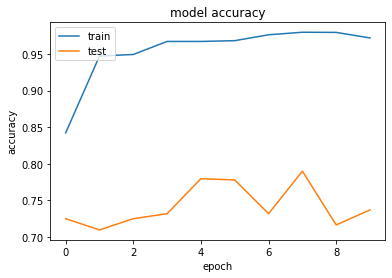

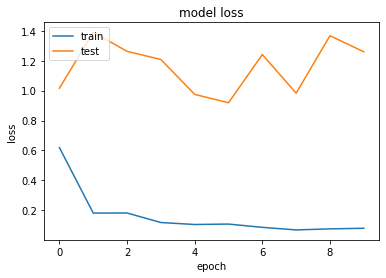

In [ ]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')


In [ ]:
 import numpy as np
 import matplotlib.pyplot as plt
 import itertools
cmap=plt.cm.Blues
title='Confusion matrix'
classes = category_names
normalize=False
figname = 'Confusion_matrix_concrete.jpg'

def plot_confusion_matrix(cm, classes, figname, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print("Confusion matrix, without normalization")
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest", cmap=cmap)
plt.title(title)
 #plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
fmt = ".2f" if normalize else "d"
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.tight_layout()
  plt.savefig(figname)

NameError: ignored

<Figure size 576x576 with 0 Axes>

In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
# plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

NameError: ignored

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False
                      , figname = 'Confusion_matrix_concrete.jpg')

Confusion matrix, without normalization


In [ ]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

NameError: ignored

# VGG19

In [ ]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions


In [ ]:
img_height, img_width = 224,224
conv_base = vgg19.VGG19(weights='imagenet', include_top=False, pooling='avg', input_shape = (img_width, img_height, 3))

In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa17fc4c588> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17fc4ca90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17fc4c710> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa17f9f8320> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17e939198> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17e939978> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa17fbc5630> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17fc1ae48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa191944278> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17e8d8908> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa17e8d8978> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa17e8f5

In [ ]:
for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten_19 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 8)                 2056      
Total params: 20,157,768
Trainable params: 133,384
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
learning_rate = 5e-5
epochs = 20
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=False, 
                              validation_data=val_generator,
                              )

Epoch 1/20
144/144 [==============================] - 27s 188ms/step - loss: 2.1202 - acc: 0.1210 - val_loss: 2.0514 - val_acc: 0.1316
Epoch 2/20
144/144 [==============================] - 27s 187ms/step - loss: 2.0587 - acc: 0.1566 - val_loss: 2.0318 - val_acc: 0.2444
Epoch 3/20
144/144 [==============================] - 27s 185ms/step - loss: 2.0447 - acc: 0.1781 - val_loss: 2.0166 - val_acc: 0.2479
Epoch 4/20
144/144 [==============================] - 27s 185ms/step - loss: 2.0290 - acc: 0.1904 - val_loss: 2.0007 - val_acc: 0.3111
Epoch 5/20
144/144 [==============================] - 27s 186ms/step - loss: 2.0179 - acc: 0.1996 - val_loss: 1.9866 - val_acc: 0.3282
Epoch 6/20
144/144 [==============================] - 27s 184ms/step - loss: 2.0047 - acc: 0.2261 - val_loss: 1.9733 - val_acc: 0.3316
Epoch 7/20
144/144 [==============================] - 27s 185ms/step - loss: 1.9932 - acc: 0.2387 - val_loss: 1.9582 - val_acc: 0.3590
Epoch 8/20
144/144 [==============================] - 2

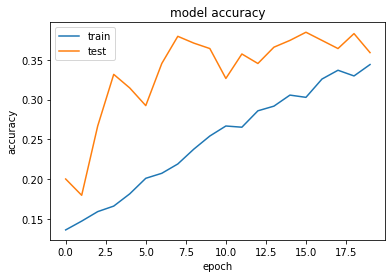

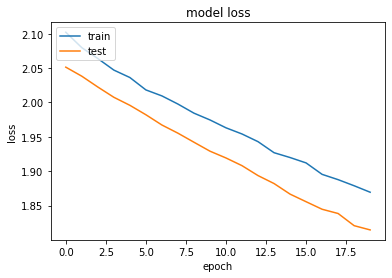

In [ ]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')


Instructions for updating:
Please use Model.predict, which supports generators.
Confusion matrix, without normalization


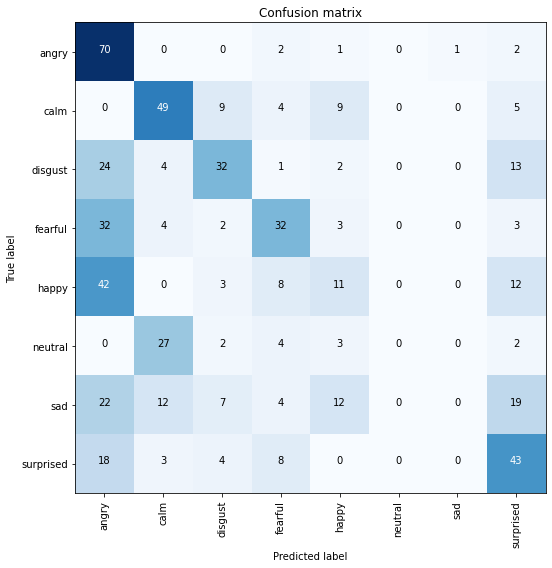

In [ ]:
 import numpy as np
 import matplotlib.pyplot as plt
 import itertools
cmap=plt.cm.Blues
title='Confusion matrix'
classes = category_names
normalize=False
figname = 'Confusion_matrix_concrete.jpg'

def plot_confusion_matrix(cm, classes, figname, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print("Confusion matrix, without normalization")
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest", cmap=cmap)
plt.title(title)
 #plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
fmt = ".2f" if normalize else "d"
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.tight_layout()
  plt.savefig(figname)

In [ ]:
# example of loading the resnet50 model
from keras.applications.resnet50 import ResNet50
# load model
model = ResNet50()
# summarize the model
model.summary()

# New VGG16

In [ ]:
from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(8, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
for layer in transfer_model.layers[:19]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_2 True
20 dense_6 True
21 dropout_2 True
22 dense_7 True
23 dense_8 True


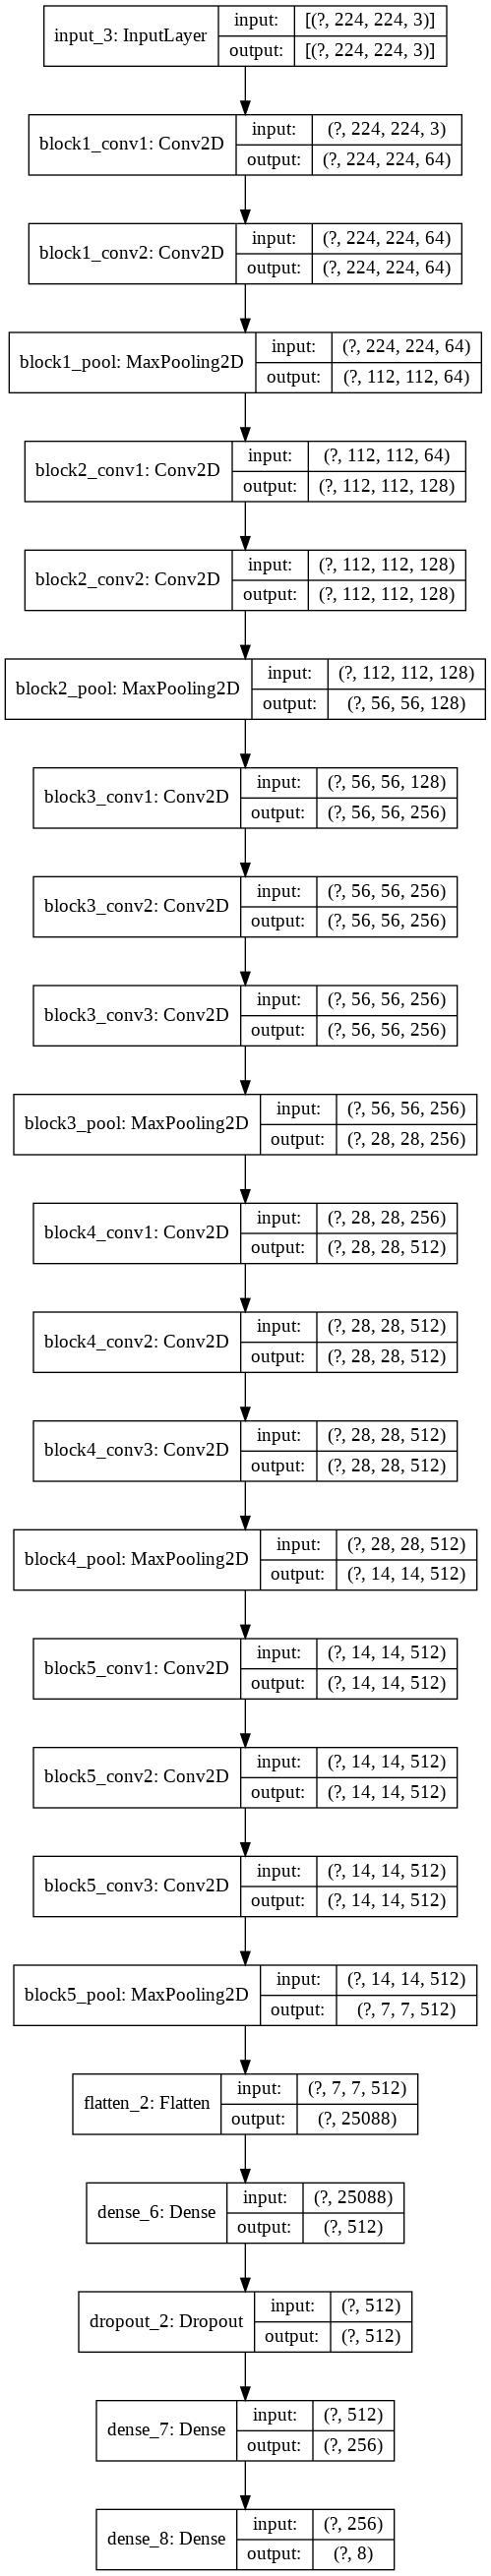

In [ ]:
keras.utils.plot_model(transfer_model, show_shapes=True)

In [ ]:

from tensorflow.keras import layers, models, Model, optimizers

learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

In [ ]:

# Here we use testing set as validation set
history = transfer_model.fit(X_train, y_train, batch_size = 16, epochs=100, validation_data=(X_test,y_test))

Epoch 1/100
252/252 [==============================] - 47s 185ms/step - loss: 1.8552 - accuracy: 0.2912 - val_loss: 1.6835 - val_accuracy: 0.3737
Epoch 2/100
252/252 [==============================] - 47s 185ms/step - loss: 1.5148 - accuracy: 0.4368 - val_loss: 1.4207 - val_accuracy: 0.4565
Epoch 3/100
252/252 [==============================] - 47s 185ms/step - loss: 1.3420 - accuracy: 0.4994 - val_loss: 1.4310 - val_accuracy: 0.4519
Epoch 4/100
252/252 [==============================] - 47s 185ms/step - loss: 1.2172 - accuracy: 0.5593 - val_loss: 1.2534 - val_accuracy: 0.5284
Epoch 5/100
252/252 [==============================] - 47s 185ms/step - loss: 1.1161 - accuracy: 0.5948 - val_loss: 1.1870 - val_accuracy: 0.5608
Epoch 6/100
252/252 [==============================] - 47s 185ms/step - loss: 1.0445 - accuracy: 0.6296 - val_loss: 1.1906 - val_accuracy: 0.5626
Epoch 7/100
252/252 [==============================] - 47s 185ms/step - loss: 0.9656 - accuracy: 0.6569 - val_loss: 1.1042 -

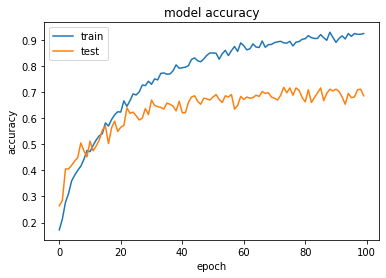

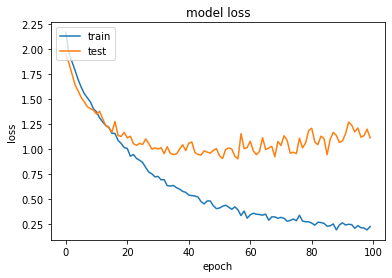

In [ ]:
        # PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()